In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from gensim.models import Word2Vec
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier 

from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score ,ConfusionMatrixDisplay

from sklearn.utils import resample

from sklearn.preprocessing import label_binarize


In [2]:
telegram = pd.read_csv('./datasets/dataset_completo_90_por_cento_sem_mensagem_similar.csv')
telegram.head()

,texto_original,frequencia,texto_limpo,text_processed,vector
0,▪️ 01/11/2022 - 08:00 \n\nÁsia-Pacífico (fecha...,24,01112022 0800 asiapacifico fechado spasx 165 6...,01112022 0800 asiapacifico fechado spasx 165 6...,[ 0.0513822 0.01934218 -0.10456374 -0.118007...
1,*02.10.2022 TSE - Governo-SP às 18h 59m 00s*,12,02102022 tse governosp as 18h 59m 00s,02102022 tse governosp 18h 59m 00s,[-7.99211636e-02 3.73514622e-01 2.03376953e-...
2,02.10.2022 TSE - Presidente - às 18h 55m 31s,15,02102022 tse presidente as 18h 55m 31s,02102022 tse presidente 18h 55m 31s,[-1.41793385e-01 4.86087143e-01 -3.60217504e-...
3,"[05:16, 02/11/2022] RICARDO JORNALISTA 2: *ENT...",164,0516 02112022 ricardo jornalista 2 entenda a d...,0516 02112022 ricardo jornalista 2 entenda dif...,[ 2.02283263e-05 1.87321693e-01 5.37611432e-...
4,▪️ 08/11/2022 - 00:00 \n\nÁsia-Pacífico\n🟢 🇦🇺S...,21,08112022 0000 asiapacifico spasx 025 695080 ni...,08112022 0000 asiapacifico spasx 025 695080 ni...,[-1.09677978e-01 -5.59413852e-03 -5.48532940e-...


In [6]:
telegram.shape

(175436, 5)

In [3]:
# Excluir as linhas onde 'text_processed' é nula, modificando o dataframe original
telegram.dropna(subset=['text_processed'], inplace=True)
telegram.shape

(175436, 5)

# Definindo as classes

In [8]:
telegram['frequencia'].describe()

count    175436.000000
mean          1.889361
std          43.376218
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max       17422.000000
Name: frequencia, dtype: float64

In [4]:
telegram = telegram[telegram['text_processed'].str.strip().str.split().apply(lambda x: len([w for w in x if w])) >= 5]
telegram.shape

(175436, 5)

In [5]:
median = telegram['frequencia'].median()
desvio = telegram['frequencia'].std()

limite_inferior = median - 2 * desvio
limite_superior = median + 2 * desvio

print(limite_inferior)
print(limite_superior)


-85.75243616059657
87.75243616059657


In [6]:
telegram['classe'] = np.where(telegram['frequencia'] >= limite_superior, 1, 0)

In [29]:
telegram.head(10)

,texto_original,frequencia,texto_limpo,text_processed,vector,classe
0,▪️ 01/11/2022 - 08:00 \n\nÁsia-Pacífico (fecha...,24,01112022 0800 asiapacifico fechado spasx 165 6...,01112022 0800 asiapacifico fechado spasx 165 6...,[ 0.0513822 0.01934218 -0.10456374 -0.118007...,0
1,*02.10.2022 TSE - Governo-SP às 18h 59m 00s*,12,02102022 tse governosp as 18h 59m 00s,02102022 tse governosp 18h 59m 00s,[-7.99211636e-02 3.73514622e-01 2.03376953e-...,0
2,02.10.2022 TSE - Presidente - às 18h 55m 31s,15,02102022 tse presidente as 18h 55m 31s,02102022 tse presidente 18h 55m 31s,[-1.41793385e-01 4.86087143e-01 -3.60217504e-...,0
3,"[05:16, 02/11/2022] RICARDO JORNALISTA 2: *ENT...",164,0516 02112022 ricardo jornalista 2 entenda a d...,0516 02112022 ricardo jornalista 2 entenda dif...,[ 2.02283263e-05 1.87321693e-01 5.37611432e-...,1
4,▪️ 08/11/2022 - 00:00 \n\nÁsia-Pacífico\n🟢 🇦🇺S...,21,08112022 0000 asiapacifico spasx 025 695080 ni...,08112022 0000 asiapacifico spasx 025 695080 ni...,[-1.09677978e-01 -5.59413852e-03 -5.48532940e-...,0
5,1 ... Baixe seu bitcoin billetera\n\n 2 ... ...,53,1 baixe seu bitcoin billetera 2 prepare seus f...,1 baixe bitcoin billetera 2 prepare fundos 3 e...,[-0.06688666 0.21346635 -0.09087458 -0.054209...,0
6,"1 E, quando Jesus ia saindo do templo, aproxim...",4,1 e quando jesus ia saindo do templo aproximar...,1 jesus ia saindo templo aproximaramse discipu...,[ 0.12920117 0.32031715 0.10017063 -0.058895...,0
7,"1, pressione o botão abaixo dentro de 3 Minuto...",608,1 pressione o botao abaixo dentro de 3 minutos...,1 pressione botao abaixo dentro 3 minutos pode...,[-1.07938409e-01 1.85984187e-02 3.46666016e-...,1
8,100% legítimo\n100% real\n100% de lucros garan...,40,100 legitimo 100 real 100 de lucros garantidos...,100 legitimo 100 real 100 lucros garantidos sa...,[-1.39069150e-03 4.95982496e-03 -2.12106362e-...,0
9,[1/11 10:00] 🌻🌻🌻: Bom dia!! Sou advogada e vou...,145,111 1000 bom dia sou advogada e vou dar um con...,111 1000 bom dia advogada vou dar conselho cas...,[ 5.45280837e-02 1.83517635e-01 1.45393703e-...,1


In [7]:
telegram['classe'].value_counts()

classe
0    175330
1       106
Name: count, dtype: int64

In [8]:
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, size=100, window=5, min_count=1, workers=4):
        self.size = size
        self.window = window
        self.min_count = min_count
        self.workers = workers
    
    def fit(self, X, y=None):
        self.w2v_model = Word2Vec(sentences=[text.split() for text in X], vector_size=self.size,
                                  window=self.window, min_count=self.min_count, workers=self.workers)
        return self
    
    def transform(self, X):
        return np.array([np.mean([self.w2v_model.wv[word] for word in text.split() if word in self.w2v_model.wv]
                                 or [np.zeros(self.size)], axis=0) for text in X])

In [9]:
vectorizers = {
    'BOW Unigram': CountVectorizer(ngram_range=(1, 1)),
    'BOW Bigram': CountVectorizer(ngram_range=(1, 2)),
    'BOW Trigram': CountVectorizer(ngram_range=(1, 3)),
    'TF-IDF Unigram': TfidfVectorizer(ngram_range=(1, 1)),
    'TF-IDF Bigram': TfidfVectorizer(ngram_range=(1, 2)),
    'TF-IDF Trigram': TfidfVectorizer(ngram_range=(1, 3)),
    'Word2Vec': Word2VecTransformer()
}

### Oversampling

In [10]:
def evaluate_model_with_outer_cv(X_train_val, y_train_val, X_test, y_test, vectorizer, vec_name, model, scaler,
                                 outer_splits=5):
    outer_cv = RepeatedStratifiedKFold(n_splits=outer_splits, n_repeats=3, random_state=42)
    all_fold_results = []

    unique_classes = np.unique(y_train_val)
    oversampling_summary = {}
    total_amostras_por_classe = {str(c): 0 for c in unique_classes}

    for train_idx, val_idx in outer_cv.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

        train_df = pd.DataFrame({'text': X_train, 'label': y_train})
        classes = train_df['label'].unique()
        dfs = [train_df[train_df['label'] == cls] for cls in classes]
        max_len = max(len(df_) for df_ in dfs)

        dfs_resampled = []
        for df_ in dfs:
            cls_label = df_['label'].iloc[0]
            current_len = len(df_)
            if current_len < max_len:
                n_to_add = max_len - current_len
                resampled_df = resample(df_, replace=True, n_samples=n_to_add, random_state=42)
                dfs_resampled.append(pd.concat([df_, resampled_df]))
                if cls_label not in oversampling_summary:
                    oversampling_summary[cls_label] = {'total_added': 0, 'example': resampled_df['text'].iloc[0]}
                oversampling_summary[cls_label]['total_added'] += n_to_add
            else:
                dfs_resampled.append(df_)

        train_df_balanced = pd.concat(dfs_resampled)
        X_train = train_df_balanced['text']
        y_train = train_df_balanced['label']

        counts = y_train.value_counts()
        for cls, count in counts.items():
            total_amostras_por_classe[str(cls)] = count

        X_train_vec = vectorizer.fit_transform(X_train)
        X_val_vec = vectorizer.transform(X_val)
        X_test_vec = vectorizer.transform(X_test)

        if scaler:
            X_train_vec = scaler.fit_transform(X_train_vec)
            X_val_vec = scaler.transform(X_val_vec)
            X_test_vec = scaler.transform(X_test_vec)

        model.fit(X_train_vec, y_train)

        y_val_pred = model.predict(X_val_vec)
        y_test_pred = model.predict(X_test_vec)

        val_report = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)
        test_report = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)

        val_accuracy = accuracy_score(y_val, y_val_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        val_f1_macro = f1_score(y_val, y_val_pred, average='macro', zero_division=0)
        test_f1_macro = f1_score(y_test, y_test_pred, average='macro', zero_division=0)
        val_f1_micro = f1_score(y_val, y_val_pred, average='micro', zero_division=0)
        test_f1_micro = f1_score(y_test, y_test_pred, average='micro', zero_division=0)
        val_f1_weighted = f1_score(y_val, y_val_pred, average='weighted', zero_division=0)
        test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

        if hasattr(model, "predict_proba"):
            y_val_proba = model.predict_proba(X_val_vec)
            y_test_proba = model.predict_proba(X_test_vec)
            if len(unique_classes) > 2:
                y_val_bin = label_binarize(y_val, classes=unique_classes)
                y_test_bin = label_binarize(y_test, classes=unique_classes)
                val_auc = roc_auc_score(y_val_bin, y_val_proba, average='macro')
                test_auc = roc_auc_score(y_test_bin, y_test_proba, average='macro')
            else:
                val_auc = roc_auc_score(y_val, y_val_proba[:, 1])
                test_auc = roc_auc_score(y_test, y_test_proba[:, 1])
        else:
            val_auc = test_auc = None

        for label in unique_classes:
            label_str = str(label)
            val_metrics = val_report.get(label_str, {'precision': 0, 'recall': 0, 'f1-score': 0})
            test_metrics = test_report.get(label_str, {'precision': 0, 'recall': 0, 'f1-score': 0})

            all_fold_results.append({
                'class': label_str,
                'val_f1_macro': val_f1_macro,
                'test_f1_macro': test_f1_macro,
                'val_f1_micro': val_f1_micro,
                'test_f1_micro': test_f1_micro,
                'val_f1_weighted': val_f1_weighted,
                'test_f1_weighted': test_f1_weighted,
                'val_precision': val_metrics['precision'],
                'test_precision': test_metrics['precision'],
                'val_recall': val_metrics['recall'],
                'test_recall': test_metrics['recall'],
                'val_f1_score': val_metrics['f1-score'],
                'test_f1_score': test_metrics['f1-score'],
                'val_accuracy': val_accuracy,
                'test_accuracy': test_accuracy,
                'val_auc_roc': val_auc,
                'test_auc_roc': test_auc,
                'Vectorizer': vec_name,
                'Model': model.__class__.__name__,
                'Scaler': scaler.__class__.__name__ if scaler else 'None'
            })

    print("Resumo final do número de amostras por classe (após oversampling):")
    for cls, total in total_amostras_por_classe.items():
        print(f" - Classe {cls}: {total} amostras")

    return pd.DataFrame(all_fold_results)


# Sem pré processamento

In [27]:
dfsp = telegram.copy()

## Regressão Logística

In [36]:
 # Separar as features e o target
X = dfsp['texto_original']
y = dfsp['classe']

# Realizar o Train-Test Split para criar um conjunto de teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [42]:
print(X.shape)
print(len(y))


(175436,)
175436


In [45]:
print(np.unique(y_train_val))
print(np.unique(y_test))


[0 1]
[0 1]


In [37]:
models = {
    'Logistic Regression': 
        LogisticRegression(
          solver='saga')

}

scalers = {

     'MaxAbsScaler': MaxAbsScaler()
}

In [44]:
results_regressao_logistica = pd.DataFrame()

for vec_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        for scaler_name, scaler in scalers.items():
            results = evaluate_model_with_outer_cv(
                X_train_val, y_train_val, X_test, y_test,
                vectorizer, vec_name, model, scaler
            )

            results_regressao_logistica = pd.concat([results_regressao_logistica, results], ignore_index=True)

            # ➕ Gera matriz de confusão final com o modelo treinado em todo treino
            X_train_final = vectorizer.fit_transform(X_train_val)
            X_test_final = vectorizer.transform(X_test)

            if scaler:
                X_train_final = scaler.fit_transform(X_train_final)
                X_test_final = scaler.transform(X_test_final)

            model.fit(X_train_final, y_train_val)
            y_test_pred_final = model.predict(X_test_final)

            cm = confusion_matrix(y_test, y_test_pred_final)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)

            fig, ax = plt.subplots(figsize=(8, 6))
            disp.plot(ax=ax, cmap='Blues')
            ax.set_title(f'Matriz de Confusão - {vec_name} - {model_name}')
            plt.savefig(f'./resultados_matriz_confusao/SemPro_regressao_{vec_name.replace(" ", "_")}_{model_name}.png')
            plt.close()

mean_results = results_regressao_logistica.groupby(['class', 'Vectorizer', 'Model', 'Scaler']).mean(numeric_only=True).reset_index()

mean_results.to_csv('./resultados/semPro_regressao.csv', index=False, encoding='utf-8')
print(mean_results)


Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
   class      Vectorizer               Model        Scaler  val_f1_macro  \
0      0      BOW Bigram  LogisticRegression  Max

## Matriz de confusão

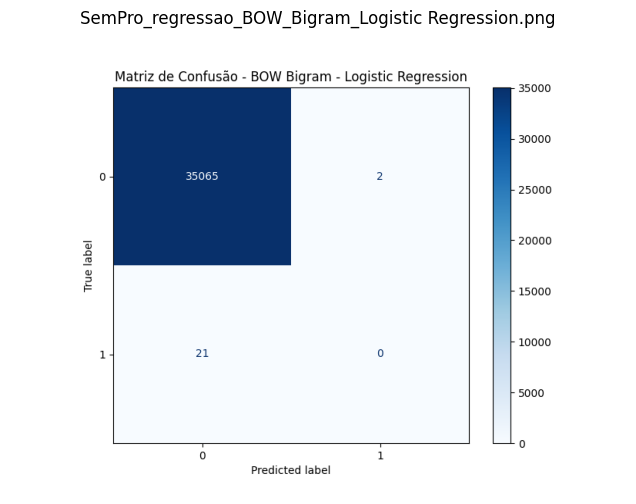

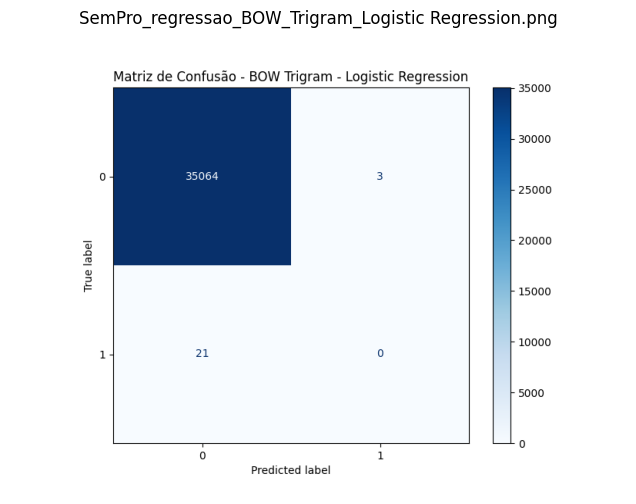

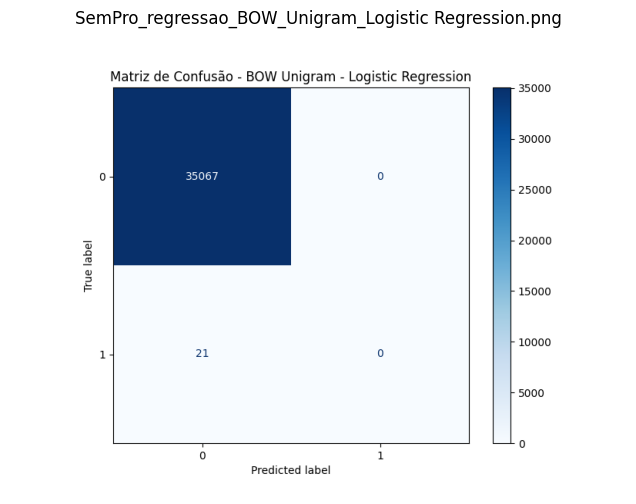

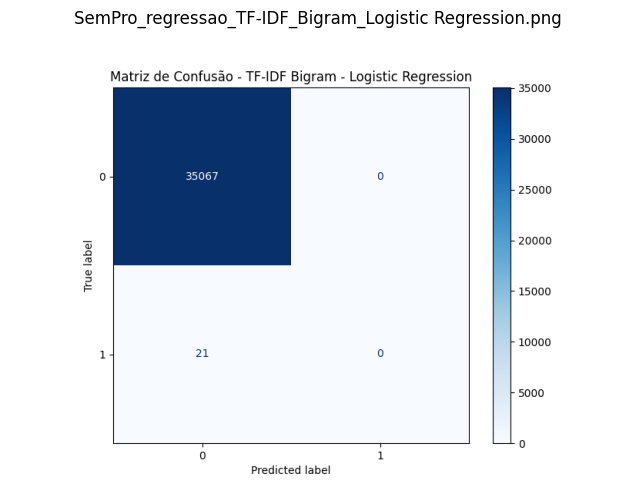

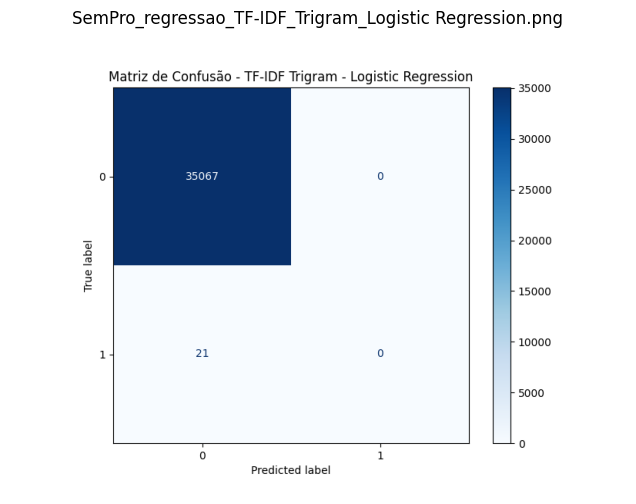

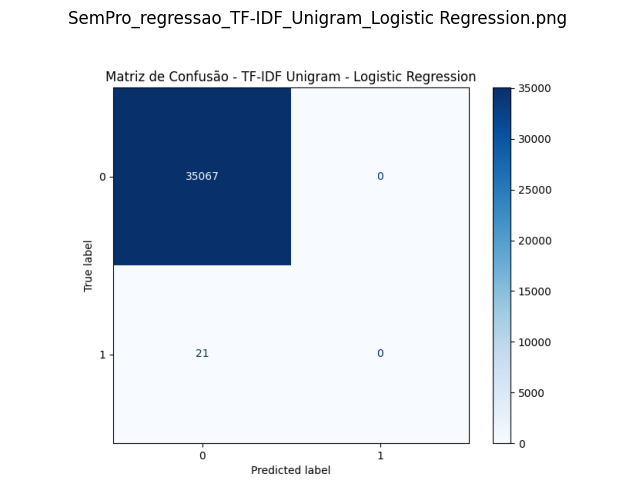

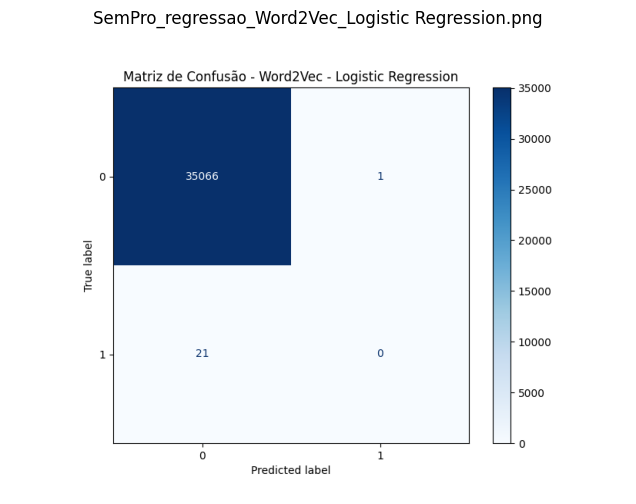

In [47]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Caminho da pasta onde as imagens estão
pasta_imagens = './resultados_matriz_confusao/'

# Lista todos os arquivos .png da pasta
imagens = [f for f in os.listdir(pasta_imagens) if f.endswith('Regression.png')]

# Ordena se quiser manter uma ordem alfabética
imagens.sort()

# Mostra uma a uma
for nome_arquivo in imagens:
    caminho_completo = os.path.join(pasta_imagens, nome_arquivo)
    img = Image.open(caminho_completo)

    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(nome_arquivo)
    plt.show()


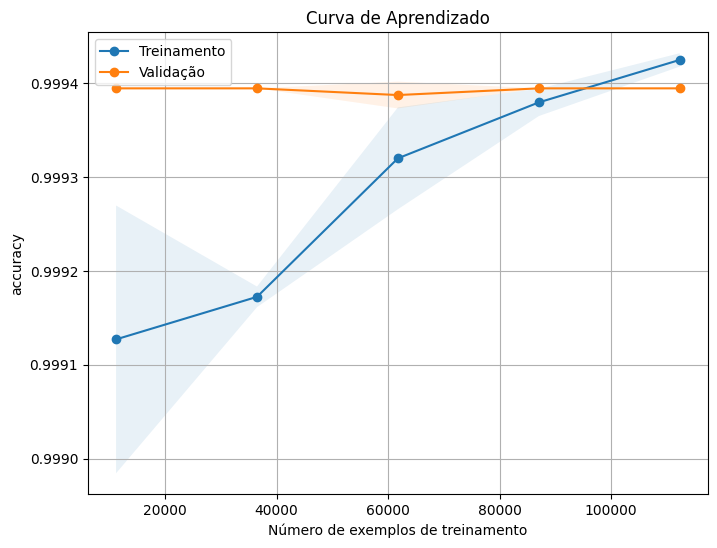

In [49]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, vectorizer=None, scaler=None, cv=5, scoring='accuracy'):
    # Vetorização
    if vectorizer:
        X = vectorizer.fit_transform(X)

    # Escalonamento
    if scaler:
        X = scaler.fit_transform(X)

    # Gera as curvas de aprendizado
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )

    # Média e desvio padrão
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', label='Treinamento')
    plt.plot(train_sizes, val_mean, 'o-', label='Validação')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
    plt.title('Curva de Aprendizado')
    plt.xlabel('Número de exemplos de treinamento')
    plt.ylabel(scoring)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

plot_learning_curve(
    model=LogisticRegression(solver='saga'),
    X=X_train_val,
    y=y_train_val,
    vectorizer=TfidfVectorizer(ngram_range=(1, 1)),
    scaler=MaxAbsScaler(),
    cv=5,
    scoring='accuracy'  
)


## Regressão Logística com regularização

In [15]:
 # Separar as features e o target
X = dfsp['texto_original']
y = dfsp['classe']

# Realizar o Train-Test Split para criar um conjunto de teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
models = {
    'Logistic Regression Lasso': 
        LogisticRegression(
          solver='saga', 
          penalty='l1')

}

scalers = {

     'MaxAbsScaler': MaxAbsScaler()
}

In [17]:
results_regressao_logistica = pd.DataFrame()

for vec_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        for scaler_name, scaler in scalers.items():
            results = evaluate_model_with_outer_cv(
                X_train_val, y_train_val, X_test, y_test,
                vectorizer, vec_name, model, scaler
            )

            results_regressao_logistica = pd.concat([results_regressao_logistica, results], ignore_index=True)

            # ➕ Gera matriz de confusão final com o modelo treinado em todo treino
            X_train_final = vectorizer.fit_transform(X_train_val)
            X_test_final = vectorizer.transform(X_test)

            if scaler:
                X_train_final = scaler.fit_transform(X_train_final)
                X_test_final = scaler.transform(X_test_final)

            model.fit(X_train_final, y_train_val)
            y_test_pred_final = model.predict(X_test_final)

            cm = confusion_matrix(y_test, y_test_pred_final)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)

            fig, ax = plt.subplots(figsize=(8, 6))
            disp.plot(ax=ax, cmap='Blues')
            ax.set_title(f'Matriz de Confusão - {vec_name} - {model_name}')
            plt.savefig(f'./resultados_matriz_confusao/SemPro_regressao_Lasso{vec_name.replace(" ", "_")}_{model_name}.png')
            plt.close()

mean_results = results_regressao_logistica.groupby(['class', 'Vectorizer', 'Model', 'Scaler']).mean(numeric_only=True).reset_index()

mean_results.to_csv('./resultados/semPro_regressao_Lasso.csv', index=False, encoding='utf-8')
print(mean_results)


Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
   class      Vectorizer               Model        Scaler  val_f1_macro  \
0      0      BOW Bigram  LogisticRegression  Max

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Caminho da pasta onde as imagens estão
pasta_imagens = './resultados_matriz_confusao/'

# Lista todos os arquivos .png da pasta
imagens = [f for f in os.listdir(pasta_imagens) if f.endswith('Lasso.png')]

# Ordena se quiser manter uma ordem alfabética
imagens.sort()

# Mostra uma a uma
for nome_arquivo in imagens:
    caminho_completo = os.path.join(pasta_imagens, nome_arquivo)
    img = Image.open(caminho_completo)

    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(nome_arquivo)
    plt.show()


## Árvore de decisão

In [18]:
 # Separar as features e o target
X = dfsp['texto_original']
y = dfsp['classe']

# Realizar o Train-Test Split para criar um conjunto de teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:

models = {
    'Decision Tree': DecisionTreeClassifier(
    criterion='entropy',             # 'gini' para medir a impureza dos nós, 'entropy' é uma alternativa
    max_depth=20,                    # Profundidade máxima da árvore para evitar overfitting
    min_samples_split=20,            # Número mínimo de amostras necessárias para dividir um nó
    min_samples_leaf=20,             # Número mínimo de amostras em um nó folha para evitar nós pequenos
    max_features='sqrt',             # Considerar a raiz quadrada do número total de características para divisões
    max_leaf_nodes=100,              # Limitar o número máximo de nós folha para controlar o tamanho da árvore
    min_impurity_decrease=0.0001    # Redução mínima de impureza necessária para realizar uma divisão
)
}

scalers = {
    'None': None
}

In [20]:
results_arvore_decisao = pd.DataFrame()

for vec_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        for scaler_name, scaler in scalers.items():
            results = evaluate_model_with_outer_cv(
                X_train_val, y_train_val, X_test, y_test,
                vectorizer, vec_name, model, scaler
            )

            results_arvore_decisao = pd.concat([results_arvore_decisao, results], ignore_index=True)

            # ➕ Gera matriz de confusão final com o modelo treinado em todo treino
            X_train_final = vectorizer.fit_transform(X_train_val)
            X_test_final = vectorizer.transform(X_test)

            if scaler:
                X_train_final = scaler.fit_transform(X_train_final)
                X_test_final = scaler.transform(X_test_final)

            model.fit(X_train_final, y_train_val)
            y_test_pred_final = model.predict(X_test_final)

            cm = confusion_matrix(y_test, y_test_pred_final)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)

            fig, ax = plt.subplots(figsize=(8, 6))
            disp.plot(ax=ax, cmap='Blues')
            ax.set_title(f'Matriz de Confusão - {vec_name} - {model_name}')
            plt.savefig(f'./resultados_matriz_confusao/SemPro_arvore_decisao{vec_name.replace(" ", "_")}_{model_name}.png')
            plt.close()

mean_results = results_arvore_decisao.groupby(['class', 'Vectorizer', 'Model', 'Scaler']).mean(numeric_only=True).reset_index()

mean_results.to_csv('./resultados/semPro_arvore_decisao.csv', index=False, encoding='utf-8')
print(mean_results)


Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
   class      Vectorizer                   Model Scaler  val_f1_macro  \
0      0      BOW Bigram  DecisionTreeClassifier   N

## Gradient Boosting

In [28]:
 # Separar as features e o target
X = dfsp['texto_original']
y = dfsp['classe']

# Realizar o Train-Test Split para criar um conjunto de teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
models = {
    'Gradiente Boosting': GradientBoostingClassifier(
        loss='log_loss',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )

}

scalers = {
    'None': None,
}

In [30]:
results_gradient_boosting = pd.DataFrame()

for vec_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        for scaler_name, scaler in scalers.items():
            results = evaluate_model_with_outer_cv(
                X_train_val, y_train_val, X_test, y_test,
                vectorizer, vec_name, model, scaler
            )

            results_gradient_boosting = pd.concat([results_gradient_boosting, results], ignore_index=True)

            # ➕ Gera matriz de confusão final com o modelo treinado em todo treino
            X_train_final = vectorizer.fit_transform(X_train_val)
            X_test_final = vectorizer.transform(X_test)

            if scaler:
                X_train_final = scaler.fit_transform(X_train_final)
                X_test_final = scaler.transform(X_test_final)

            model.fit(X_train_final, y_train_val)
            y_test_pred_final = model.predict(X_test_final)

            cm = confusion_matrix(y_test, y_test_pred_final)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)

            fig, ax = plt.subplots(figsize=(8, 6))
            disp.plot(ax=ax, cmap='Blues')
            ax.set_title(f'Matriz de Confusão - {vec_name} - {model_name}')
            plt.savefig(f'SemPro_gradient_boosting{vec_name.replace(" ", "_")}_{model_name}.png')
            plt.close()
            

mean_results = results_gradient_boosting.groupby(['class', 'Vectorizer', 'Model', 'Scaler']).mean(numeric_only=True).reset_index()

mean_results.to_csv('semPro_gradient_boosting.csv', index=False, encoding='utf-8')
print(mean_results)


Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
   class      Vectorizer                       Model Scaler  val_f1_macro  \
0      0      BOW Bigram  GradientBoostingClassi

# Com pré processamento

In [12]:
dfcp = telegram.copy()

## Regressão Logística

In [13]:
 # Separar as features e o target
X = dfcp['text_processed']
y = dfcp['classe']

# Realizar o Train-Test Split para criar um conjunto de teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
models = {
    'Logistic Regression': 
        LogisticRegression(
          solver='saga')

}

scalers = {

     'MaxAbsScaler': MaxAbsScaler()
}

In [15]:
results_regressao_logistica = pd.DataFrame()

for vec_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        for scaler_name, scaler in scalers.items():
            results = evaluate_model_with_outer_cv(
                X_train_val, y_train_val, X_test, y_test,
                vectorizer, vec_name, model, scaler
            )

            results_regressao_logistica = pd.concat([results_regressao_logistica, results], ignore_index=True)

            # ➕ Gera matriz de confusão final com o modelo treinado em todo treino
            X_train_final = vectorizer.fit_transform(X_train_val)
            X_test_final = vectorizer.transform(X_test)

            if scaler:
                X_train_final = scaler.fit_transform(X_train_final)
                X_test_final = scaler.transform(X_test_final)

            model.fit(X_train_final, y_train_val)
            y_test_pred_final = model.predict(X_test_final)

            cm = confusion_matrix(y_test, y_test_pred_final)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)

            fig, ax = plt.subplots(figsize=(8, 6))
            disp.plot(ax=ax, cmap='Blues')
            ax.set_title(f'Matriz de Confusão - {vec_name} - {model_name}')
            plt.savefig(f'ComPro_regressao{vec_name.replace(" ", "_")}_{model_name}.png')
            plt.close()

mean_results = results_regressao_logistica.groupby(['class', 'Vectorizer', 'Model', 'Scaler']).mean(numeric_only=True).reset_index()

mean_results.to_csv('ComPro_regressao.csv', index=False, encoding='utf-8')
print(mean_results)


Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
   class      Vectorizer               Model        Scaler  val_f1_macro  \
0      0      BOW Bigram  LogisticRegression  Max

## Regressão Logística Com regularização

In [16]:
 # Separar as features e o target
X = dfcp['text_processed']
y = dfcp['classe']

# Realizar o Train-Test Split para criar um conjunto de teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
models = {
    'Logistic Regression Lasso': 
        LogisticRegression(
          solver='saga', 
          penalty='l1')

}

scalers = {

     'MaxAbsScaler': MaxAbsScaler()
}

In [18]:
results_regressao_logistica = pd.DataFrame()

for vec_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        for scaler_name, scaler in scalers.items():
            results = evaluate_model_with_outer_cv(
                X_train_val, y_train_val, X_test, y_test,
                vectorizer, vec_name, model, scaler
            )

            results_regressao_logistica = pd.concat([results_regressao_logistica, results], ignore_index=True)

            # ➕ Gera matriz de confusão final com o modelo treinado em todo treino
            X_train_final = vectorizer.fit_transform(X_train_val)
            X_test_final = vectorizer.transform(X_test)

            if scaler:
                X_train_final = scaler.fit_transform(X_train_final)
                X_test_final = scaler.transform(X_test_final)

            model.fit(X_train_final, y_train_val)
            y_test_pred_final = model.predict(X_test_final)

            cm = confusion_matrix(y_test, y_test_pred_final)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)

            fig, ax = plt.subplots(figsize=(8, 6))
            disp.plot(ax=ax, cmap='Blues')
            ax.set_title(f'Matriz de Confusão - {vec_name} - {model_name}')
            plt.savefig(f'ComPro_regressao_Lasso{vec_name.replace(" ", "_")}_{model_name}.png')
            plt.close()

mean_results = results_regressao_logistica.groupby(['class', 'Vectorizer', 'Model', 'Scaler']).mean(numeric_only=True).reset_index()

mean_results.to_csv('comPro_regressao_Lasso.csv', index=False, encoding='utf-8')
print(mean_results)


Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
   class      Vectorizer               Model        Scaler  val_f1_macro  \
0      0      BOW Bigram  LogisticRegression  Max

## Árvore de decisão

In [19]:
 # Separar as features e o target
X = dfcp['text_processed']
y = dfcp['classe']

# Realizar o Train-Test Split para criar um conjunto de teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:

models = {
    'Decision Tree': DecisionTreeClassifier(
    criterion='entropy',             # 'gini' para medir a impureza dos nós, 'entropy' é uma alternativa
    max_depth=20,                    # Profundidade máxima da árvore para evitar overfitting
    min_samples_split=20,            # Número mínimo de amostras necessárias para dividir um nó
    min_samples_leaf=20,             # Número mínimo de amostras em um nó folha para evitar nós pequenos
    max_features='sqrt',             # Considerar a raiz quadrada do número total de características para divisões
    max_leaf_nodes=100,              # Limitar o número máximo de nós folha para controlar o tamanho da árvore
    min_impurity_decrease=0.0001    # Redução mínima de impureza necessária para realizar uma divisão
)
}

scalers = {
    'None': None
}

In [21]:
results_arvore_decisao = pd.DataFrame()

for vec_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        for scaler_name, scaler in scalers.items():
            results = evaluate_model_with_outer_cv(
                X_train_val, y_train_val, X_test, y_test,
                vectorizer, vec_name, model, scaler
            )

            results_arvore_decisao = pd.concat([results_arvore_decisao, results], ignore_index=True)

            # ➕ Gera matriz de confusão final com o modelo treinado em todo treino
            X_train_final = vectorizer.fit_transform(X_train_val)
            X_test_final = vectorizer.transform(X_test)

            if scaler:
                X_train_final = scaler.fit_transform(X_train_final)
                X_test_final = scaler.transform(X_test_final)

            model.fit(X_train_final, y_train_val)
            y_test_pred_final = model.predict(X_test_final)

            cm = confusion_matrix(y_test, y_test_pred_final)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)

            fig, ax = plt.subplots(figsize=(8, 6))
            disp.plot(ax=ax, cmap='Blues')
            ax.set_title(f'Matriz de Confusão - {vec_name} - {model_name}')
            plt.savefig(f'comPro_arvore_decisao{vec_name.replace(" ", "_")}_{model_name}.png')
            plt.close()

mean_results = results_arvore_decisao.groupby(['class', 'Vectorizer', 'Model', 'Scaler']).mean(numeric_only=True).reset_index()

mean_results.to_csv('comPro_arvore_decisao.csv', index=False, encoding='utf-8')
print(mean_results)


Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
   class      Vectorizer                   Model Scaler  val_f1_macro  \
0      0      BOW Bigram  DecisionTreeClassifier   N

## Gradient Boosting

In [22]:
 # Separar as features e o target
X = dfcp['text_processed']
y = dfcp['classe']

# Realizar o Train-Test Split para criar um conjunto de teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
models = {
    'Gradiente Boosting': GradientBoostingClassifier(
        loss='log_loss',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )

}

scalers = {
    'None': None,
}

In [24]:
results_gradient_boosting = pd.DataFrame()

for vec_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        for scaler_name, scaler in scalers.items():
            results = evaluate_model_with_outer_cv(
                X_train_val, y_train_val, X_test, y_test,
                vectorizer, vec_name, model, scaler
            )

            results_gradient_boosting = pd.concat([results_gradient_boosting, results], ignore_index=True)

            # ➕ Gera matriz de confusão final com o modelo treinado em todo treino
            X_train_final = vectorizer.fit_transform(X_train_val)
            X_test_final = vectorizer.transform(X_test)

            if scaler:
                X_train_final = scaler.fit_transform(X_train_final)
                X_test_final = scaler.transform(X_test_final)

            model.fit(X_train_final, y_train_val)
            y_test_pred_final = model.predict(X_test_final)

            cm = confusion_matrix(y_test, y_test_pred_final)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)

            fig, ax = plt.subplots(figsize=(8, 6))
            disp.plot(ax=ax, cmap='Blues')
            ax.set_title(f'Matriz de Confusão - {vec_name} - {model_name}')
            plt.savefig(f'ComPro_gradient_boosting{vec_name.replace(" ", "_")}_{model_name}.png')
            plt.close()

mean_results = results_gradient_boosting.groupby(['class', 'Vectorizer', 'Model', 'Scaler']).mean(numeric_only=True).reset_index()

mean_results.to_csv('comPro_gradient_boosting.csv', index=False, encoding='utf-8')
print(mean_results)


Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
Resumo final do número de amostras por classe (após oversampling):
 - Classe 0: 112211 amostras
 - Classe 1: 112211 amostras
   class      Vectorizer                       Model Scaler  val_f1_macro  \
0      0      BOW Bigram  GradientBoostingClassi